### Move Image Into One Folder:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -rf /content/extract_lfw

In [ ]:
!tar -xzvf '/content/drive/MyDrive/ML/lfw-funneled.tgz' -C "/content"


Streaming output truncated to the last 5000 lines.
lfw_funneled/Guillaume_Depardieu/Guillaume_Depardieu_0001.jpg
lfw_funneled/Delphine_Chuillot/
lfw_funneled/Delphine_Chuillot/Delphine_Chuillot_0001.jpg
lfw_funneled/Paul_LeClerc/
lfw_funneled/Paul_LeClerc/Paul_LeClerc_0001.jpg
lfw_funneled/Eddie_Jordan/
lfw_funneled/Eddie_Jordan/Eddie_Jordan_0001.jpg
lfw_funneled/Lionel_Richie/
lfw_funneled/Lionel_Richie/Lionel_Richie_0001.jpg
lfw_funneled/Lionel_Richie/Lionel_Richie_0002.jpg
lfw_funneled/Jose_Viegas_Filho/
lfw_funneled/Jose_Viegas_Filho/Jose_Viegas_Filho_0001.jpg
lfw_funneled/Jose_Viegas_Filho/Jose_Viegas_Filho_0002.jpg
lfw_funneled/Roger_Mahony/
lfw_funneled/Roger_Mahony/Roger_Mahony_0001.jpg
lfw_funneled/Clay_Aiken/
lfw_funneled/Clay_Aiken/Clay_Aiken_0001.jpg
lfw_funneled/Clay_Aiken/Clay_Aiken_0002.jpg
lfw_funneled/Clay_Aiken/Clay_Aiken_0003.jpg
lfw_funneled/Clay_Aiken/Clay_Aiken_0004.jpg
lfw_funneled/Clay_Aiken/Clay_Aiken_0005.jpg
lfw_funneled/Clay_Aiken/Clay_Aiken_0006.jpg
lfw_fun

In [15]:
!pip install opencv-python
!pip install imbalanced-learn
!pip install opencv-python numpy matplotlib scikit-learn imbalanced-learn keras
!pip install joblib
!pip install imgaug

     ---------------------------------------- 0.0/948.0 kB ? eta -:--:--
     ---------------------------------------- 10.2/948.0 kB ? eta -:--:--
     - ----------------------------------- 30.7/948.0 kB 445.2 kB/s eta 0:00:03
     --- --------------------------------- 81.9/948.0 kB 657.6 kB/s eta 0:00:02
     ------- ------------------------------ 194.6/948.0 kB 1.3 MB/s eta 0:00:01
     ---------------------- --------------- 573.4/948.0 kB 2.8 MB/s eta 0:00:01
     -------------------------------------  942.1/948.0 kB 4.0 MB/s eta 0:00:01
     -------------------------------------- 948.0/948.0 kB 3.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------- ----------------------- 0.6/1.4 MB 12.2 MB/s eta 0:00:01
   ------------------------------- -------- 1.1/1.4 MB 12.1 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 11.4 MB/s eta 0:00:00


Import Library

In [10]:
import os
import cv2
import numpy as np
import pathlib
import shutil
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import accuracy_score
from scipy.stats import loguniform
from sklearn.decomposition import PCA
from imblearn.over_sampling import ADASYN
from sklearn.utils import shuffle
from scipy import ndimage
from skimage import transform


Crop Function Below

In [3]:
def preprocess_and_augment_image(face_classifier: cv2.CascadeClassifier, image, target_size=(64, 64), x=100, y=100, crop_width=800, crop_height=800):
    img = cv2.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, scaleFactor=1.05, minNeighbors=4, minSize=(105, 105))

    if len(faces) > 0:

        x, y, w, h = faces[0]


        img = img[y:y + h, x:x + w]

    else:
        print(f"No face detected in {image}. Performing a normal crop.")
        img = img[y:y + crop_height, x:x + crop_width]


    img = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)

    return img


Extract Image Into One Directory and Crop:

In [4]:
def moveImg(source_folder, target_folder):
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    for person in os.listdir(source_folder):
        person_folder = os.path.join(source_folder, person)
        if os.path.isdir(person_folder):
            image_count = len([filename for filename in os.listdir(person_folder) if filename.endswith('.jpg')])
            if image_count >= 20:
                # Check if the person's folder already exists in the target directory
                person_target_folder = os.path.join(target_folder, person)
                if not os.path.exists(person_target_folder):
                    shutil.copytree(person_folder, person_target_folder)
                else:
                    print(f"Folder '{person}' already exists in the target directory.")

In [6]:
lfw_path = pathlib.Path('lfw_funneled')

new_path = pathlib.Path('extract_lfw')
if os.path.exists(lfw_path) and os.path.isdir(lfw_path):
    print(f"'{lfw_path}' directory exists.")
else:
    print(f"'{lfw_path}' directory does not exist.")

if not os.path.exists(new_path):
    os.mkdir(new_path)

moveImg(lfw_path,new_path)

'lfw_funneled' directory exists.


Clean Data:

In [ ]:
folder_path = 'extract_lfw'


face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades+"haarcascade_frontalface_default.xml")
for person in os.listdir(folder_path):
    person_folder = os.path.join(folder_path, person)
    if os.path.isdir(person_folder):
        for filename in os.listdir(person_folder):
            if filename.endswith('.jpg'):
                image_path = os.path.join(person_folder, filename)
                preprocessed_image = preprocess_and_augment_image(face_classifier, image_path)
                cv2.imwrite(image_path, preprocessed_image)

Image Visualization:

In [3]:

folder_path = 'extract_lfw'
df_images = []
labels = []

for label, person in enumerate(os.listdir(folder_path)):
    if os.path.isdir(os.path.join(folder_path, person)):
        image_files = [filename for filename in os.listdir(os.path.join(folder_path, person)) if filename.endswith('.jpg')]

        if image_files:
            for filename in image_files:
                img_path = os.path.join(folder_path, person, filename)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = img.flatten()
                
                df_images.append(img)
                labels.append(person)  
        else:
            print(f"Skipping '{person}' due to no images in the subfolder.")

df_images = np.array(df_images)
labels = np.array(labels)


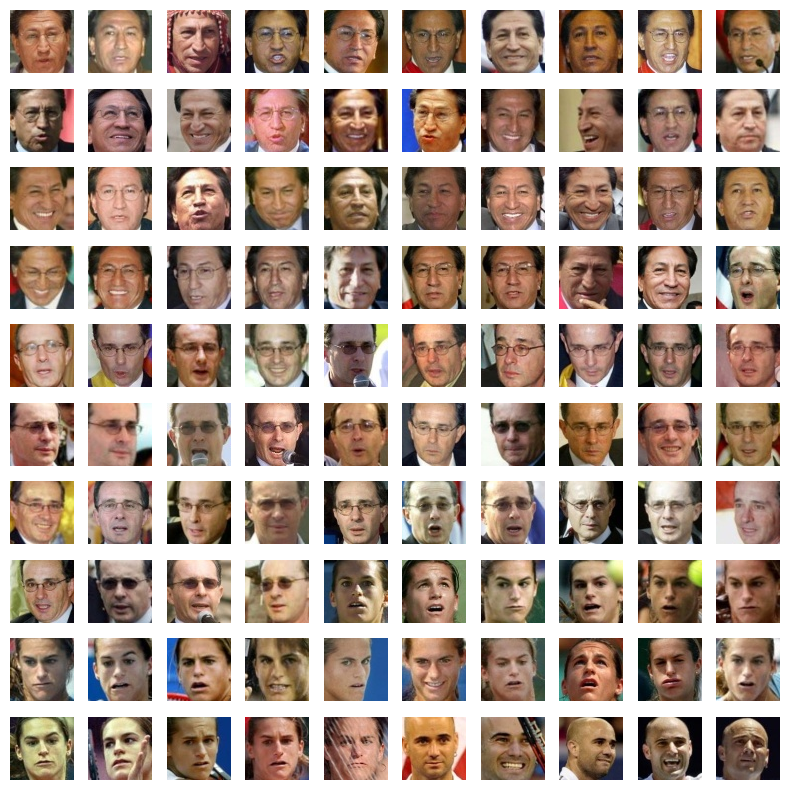

In [4]:
image_shape = (64, 64,3)
num_rows = 10
num_cols = 10

plt.figure(figsize=(8, 8))
for i in range(num_rows * num_cols):
    img = df_images[i].reshape(image_shape)
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(img)  # Convert BGR to RGB for display
    plt.axis('off')

plt.tight_layout()
plt.show()


Folder visualization:

In [13]:
class_mapping = {}
class_images = {}


directory_path = "extract_lfw"

for index, directory in enumerate(os.listdir(directory_path)):
    class_mapping[index] = directory
    class_images[index] = len(os.listdir(os.path.join(directory_path, directory)))


print("Class Mapping:", class_mapping)
print("Number of Images per Class:", class_images)


Class Mapping: {0: 'Alejandro_Toledo', 1: 'Alvaro_Uribe', 2: 'Amelie_Mauresmo', 3: 'Andre_Agassi', 4: 'Angelina_Jolie', 5: 'Ariel_Sharon', 6: 'Arnold_Schwarzenegger', 7: 'Atal_Bihari_Vajpayee', 8: 'Bill_Clinton', 9: 'Carlos_Menem', 10: 'Colin_Powell', 11: 'David_Beckham', 12: 'Donald_Rumsfeld', 13: 'George_Robertson', 14: 'George_W_Bush', 15: 'Gerhard_Schroeder', 16: 'Gloria_Macapagal_Arroyo', 17: 'Gray_Davis', 18: 'Guillermo_Coria', 19: 'Hamid_Karzai', 20: 'Hans_Blix', 21: 'Hugo_Chavez', 22: 'Igor_Ivanov', 23: 'Jack_Straw', 24: 'Jacques_Chirac', 25: 'Jean_Chretien', 26: 'Jennifer_Aniston', 27: 'Jennifer_Capriati', 28: 'Jennifer_Lopez', 29: 'Jeremy_Greenstock', 30: 'Jiang_Zemin', 31: 'John_Ashcroft', 32: 'John_Negroponte', 33: 'Jose_Maria_Aznar', 34: 'Juan_Carlos_Ferrero', 35: 'Junichiro_Koizumi', 36: 'Kofi_Annan', 37: 'Laura_Bush', 38: 'Lindsay_Davenport', 39: 'Lleyton_Hewitt', 40: 'Luiz_Inacio_Lula_da_Silva', 41: 'Mahmoud_Abbas', 42: 'Megawati_Sukarnoputri', 43: 'Michael_Bloomberg', 

In [ ]:
total_num_images = np.sum(list(class_images.values()))
print("Individual \t Composition of Dataset\n")
for label, num_images in class_images.items():
 print("{:20} {:.2f}%".format(
 class_mapping[label], (num_images / total_num_images) * 100))

Individual 	 Composition of Dataset

Jose_Maria_Aznar     0.76%
Jean_Chretien        1.82%
Vicente_Fox          1.06%
Jeremy_Greenstock    0.79%
Tom_Ridge            1.09%
Vladimir_Putin       1.62%
Jiang_Zemin          0.66%
Jennifer_Aniston     0.69%
Pete_Sampras         0.73%
Tom_Daschle          0.83%
Recep_Tayyip_Erdogan 0.99%
Roh_Moo-hyun         1.06%
Amelie_Mauresmo      0.69%
Gloria_Macapagal_Arroyo 1.46%
George_Robertson     0.73%
Rudolph_Giuliani     0.86%
Alejandro_Toledo     1.29%
Naomi_Watts          0.73%
Jack_Straw           0.93%
Hans_Blix            1.29%
Andre_Agassi         1.19%
Laura_Bush           1.36%
Jennifer_Capriati    1.39%
Lleyton_Hewitt       1.36%
Paul_Bremer          0.66%
Junichiro_Koizumi    1.98%
David_Beckham        1.03%
John_Negroponte      1.03%
Hamid_Karzai         0.73%
Michael_Bloomberg    0.66%
Gray_Davis           0.86%
Serena_Williams      1.72%
Ricardo_Lagos        0.89%
Guillermo_Coria      0.99%
Lindsay_Davenport    0.73%
Luiz_Inacio_Lul

Split Data:

In [5]:
df_images, labels = shuffle(df_images, labels)

In [6]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_images, labels, test_size=0.25, random_state=42)
df_images = 0
labels = 0
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(2267, 12288) (2267,)
(756, 12288) (756,)


In [7]:
X_train = X_train/255.0
X_test = X_test /255.0

In [8]:
Adsyn = ADASYN()
X_train, y_train = Adsyn.fit_resample(X_train, y_train)
print(X_train.shape)
print(y_train.shape)

(25264, 12288)
(25264,)


In [11]:
def rotate_image(image, angle):
    return ndimage.rotate(image, angle, reshape=False)

def flip_image(image):
    return np.fliplr(image)

def change_brightness(image, factor):
    return np.clip(image * factor, 0, 255)

def shear_image(image, intensity):
    afine_tf = transform.AffineTransform(shear=intensity)
    return transform.warp(image, afine_tf)
augmented_images = []
augmented_labels = []

X_train_reshaped = X_train.reshape(X_train.shape[0], 64, 64, 3)

for idx, image in enumerate(X_train_reshaped):
    rotation_angle = np.random.randint(-10, 10) 
    horizontal_flip = np.random.choice([True, False])  
    brightness_factor = np.random.uniform(0.5, 1.5)  
    shear_intensity = np.random.uniform(-0.2, 0.2)  
    rotated_image = rotate_image(image, angle=rotation_angle)
    flipped_image = flip_image(rotated_image) if horizontal_flip else rotated_image
    brightness_adjusted_image = change_brightness(flipped_image, factor=brightness_factor)
    sheared_image = shear_image(brightness_adjusted_image, intensity=shear_intensity)
    augmented_images.append(sheared_image)
    augmented_labels.append(y_train[idx])

augmented_images_array = np.array(augmented_images)
augmented_labels_array = np.array(augmented_labels)
augmented_images_array = augmented_images_array.reshape(augmented_images_array.shape[0], -1)

# Concatenate original X_train and augmented_images
augmented_data  = np.concatenate((X_train, augmented_images_array), axis=0)

# Concatenate original y_train and augmented_labels
augmented_labels = np.concatenate((y_train, augmented_labels_array), axis=0)


In [12]:
print(augmented_data.shape)
print(augmented_labels.shape)

(50528, 12288)
(50528,)


In [13]:
scaler = StandardScaler()
augmented_data = scaler.fit_transform(augmented_data)
X_test= scaler.transform(X_test)

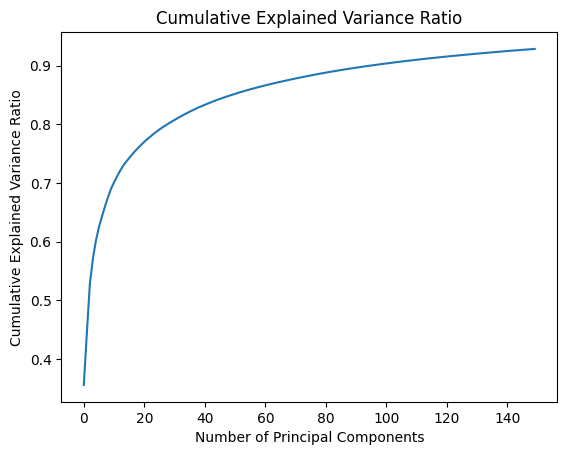

X_train_pca shape: (50528, 150)
X_test_pca shape: (756, 150)


In [14]:
pca = PCA(n_components=150,svd_solver="randomized",whiten=True)
X_train_pca = pca.fit_transform(augmented_data)


X_test_pca = pca.transform(X_test)

cumulative_var_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_var_ratio)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio')
plt.show()


print("X_train_pca shape:", X_train_pca.shape)
print("X_test_pca shape:", X_test_pca.shape)

In [15]:

Svm = SVC(C= 1.4872681066575715, gamma= 0.003293320249656128, kernel= "rbf", class_weight="balanced")
Svm.fit(X_train_pca, augmented_labels)


y_pred =Svm.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.73


In [16]:
param_grid = {
    "C": loguniform(1e1, 1e3),  # Adjusted range for 'C'
    "gamma": loguniform(1e-5, 1e-1)
}

# Use a scoring metric, such as accuracy
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, cv=5, scoring='accuracy', n_iter=10, n_jobs=5
)

clf.fit(X_train_pca, augmented_labels)
best_params = clf.best_params_
print("Best Parameters:", best_params)

y_pred = clf.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Best Parameters: {'C': 23.530965834720774, 'gamma': 0.005036955111889292}
Accuracy: 0.72


In [14]:
from sklearn.metrics import classification_report

# Use the classification_report with target_names parameter
report = classification_report(y_test, y_pred)

print(report)


                           precision    recall  f1-score   support

         Alejandro_Toledo       0.75      0.67      0.71         9
             Alvaro_Uribe       0.55      0.67      0.60         9
          Amelie_Mauresmo       0.50      1.00      0.67         1
             Andre_Agassi       0.46      0.67      0.55         9
           Angelina_Jolie       0.40      1.00      0.57         2
             Ariel_Sharon       0.68      0.72      0.70        18
    Arnold_Schwarzenegger       0.29      0.40      0.33        10
     Atal_Bihari_Vajpayee       1.00      0.43      0.60         7
             Bill_Clinton       0.67      0.50      0.57         8
             Carlos_Menem       0.60      0.60      0.60         5
             Colin_Powell       0.85      0.91      0.88        56
            David_Beckham       0.31      0.44      0.36         9
          Donald_Rumsfeld       0.83      0.65      0.73        37
         George_Robertson       0.50      0.50      0.50     

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [17]:
import joblib

joblib.dump(Svm, 'svm_model.pkl')

['svm_model.pkl']

In [18]:
joblib.dump(pca, 'pca_model.joblib')
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']